# Importing Libraries

In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import base64
import requests
import os
from datetime import datetime
import feedparser


# Define Functions

In [178]:
api_key = os.getenv("OPENAI_API_KEY")

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Function to get the most recent image file
def get_most_recent_image(directory):
    files = [f for f in os.listdir(directory) if f.endswith(".jpg")]
    if not files:
        raise FileNotFoundError("No .jpg files found in the directory.")

    # Get the full paths and sort by modification time
    full_paths = [os.path.join(directory, f) for f in files]
    most_recent_file = max(full_paths, key=os.path.getmtime)
    return most_recent_file

def img_analyze():
    # Corrected image directory path with leading '/'
    image_directory = "/Users/diproc/Documents/np_rand/hacks/mathxai/venv/plots"

    # Get the most recent image file
    image_path = get_most_recent_image(image_directory)

    # Getting the base64 string
    base64_image = encode_image(image_path)

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    payload = {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze this figure output by change point detection that has already been performed. Evaluate whether the change point detections are in a reasonable place, and think of a score from 1 to 10 based on how appropriate the change point detection looks, where 10 is great and 0 is poor. The key thing to understand is whether or not the change point regions look like they are in a reasonable place. At the end, also return 0 if the change pt detection was poor or 1 if it looks promising. If there is only one color (blue), then clearly no change point detection occurred and you would need to return a low score by default. ONLY Return all elements of this analysis on JSON format, including evaluation, final evaluation, and binary indicator."
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "high"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    # Extracting the content
    response_json = response.json()
    content = response_json['choices'][0]['message']['content']

    print('\n')
    print("Analysis: ", content)

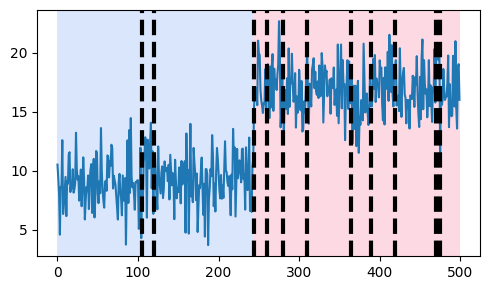

In [75]:
# creation of data
n, dim = 500, 1
n_bkps, sigma = 1, 2
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(pen=3)

# show results
fig, ax_arr = rpt.display(signal, bkps, my_bkps, figsize=(5, 3))
plt.show()

# save fig to file
folder_path = "plots"
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"figure_{current_time}.jpg"
file_path = os.path.join(folder_path, file_name)
fig.savefig(file_path, format="jpeg")

In [80]:
img_analyze()



Analysis:  To evaluate the change point detection in the figure:

1. **Number of Dotted Lines**: There appear to be multiple dotted lines, which suggests that there may be multiple change points identified. For binary segmentation, ideally, there should only be one dotted line.

2. **Location of Dotted Lines**: The placement of the dotted lines should ideally separate the two segments clearly. It seems like the lines are spread across the range rather than demarcating a clear change.

Based on these observations, I would rate the appropriateness of the change point detection as a **2 out of 10**. The detection is poor because it does not adhere to the requirement for binary segmentation with a single change point.

Final score: **0** (indicating that the change point detection was poor).


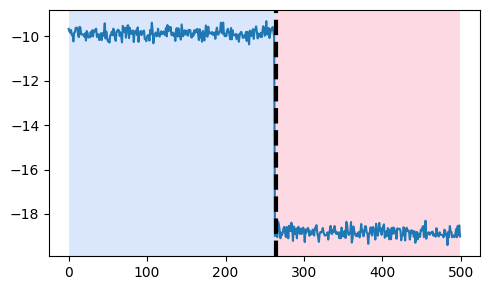

In [81]:
# creation of data
n, dim = 500, 1
n_bkps, sigma = 1, 0.2
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(pen=10)

# show results
fig, ax_arr = rpt.display(signal, bkps, my_bkps, figsize=(5, 3))
plt.show()

# save fig to file
folder_path = "plots"
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"figure_{current_time}.jpg"
file_path = os.path.join(folder_path, file_name)
fig.savefig(file_path, format="jpeg")

In [82]:
img_analyze()



Analysis:  Based on your description of the figure output from the change point detection:

1. **Binary Segmentation**: The figure shows a clear binary segmentation, with a single dotted line marking the change point.
  
2. **Placement of the Dotted Line**: The dotted line appears to be located between two segments that exhibit different statistical properties. The left part (blue) seems fairly stable, while the right part (pink) shows a different mean or behavior, suggesting the presence of a legitimate change point.

3. **Evaluation**: Given that there is only one dotted line and its placement seems to appropriately indicate a change in the data, I would rate the appropriateness of this change point detection as an 8 out of 10. The only consideration for a lower score might be the variability within each segment, but that isn’t evident here without further data context.

**Final Score**: 8  
**Binary Indicator**: 1 (it looks promising)


In [88]:
img_analyze()



Analysis:  ```json
{
  "segmentation": {
    "num_change_points": 1,
    "change_point_position": 300
  },
  "evaluation": {
    "dotted_line_position": "reasonable",
    "data_behavior_before_and_after": "distinct"
  },
  "final_evaluation": 8,
  "binary_indicator": 1
}
```


# Try on Real World Data

Function to extract real world publication data on a certain topic. Let's try fractals 🤪

In [97]:
# Function to fetch data from arXiv
def fetch_arxiv_data(query, max_results=10000):
    base_url = "http://export.arxiv.org/api/query?"
    params = f"search_query={query}&start=0&max_results={max_results}&sortBy=submittedDate&sortOrder=ascending"
    response = requests.get(base_url + params)
    return feedparser.parse(response.text)

query_subject = "fractals"
# Example: Get publications mentioning the specified subject
query = f"all:{query_subject}"
data = fetch_arxiv_data(query)

# Parse data into a DataFrame
records = []
for entry in data.entries:
    pub_date = datetime.strptime(entry.published, "%Y-%m-%dT%H:%M:%SZ")
    records.append({
        "title": entry.title,
        "published_year": pub_date.year
    })
df = pd.DataFrame(records)

# Group by year and count publications
publications_per_year = df['published_year'].value_counts().sort_index()
# Convert the publications_per_year series into a DataFrame
publications_per_year_df = publications_per_year.reset_index()
# Rename the columns for clarity
publications_per_year_df.columns = ["year", "publication_count"]
# Display the DataFrame
print(publications_per_year_df)

In [108]:
# extract the value_as_float column as a numpy array
values = publications_per_year_df['publication_count'].values

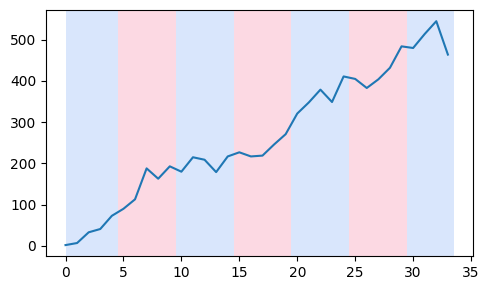

In [111]:
# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(values)
my_bkps = algo.predict(pen=10)

# show results
fig, ax_arr = rpt.display(values, my_bkps, figsize=(5, 3))
plt.show()

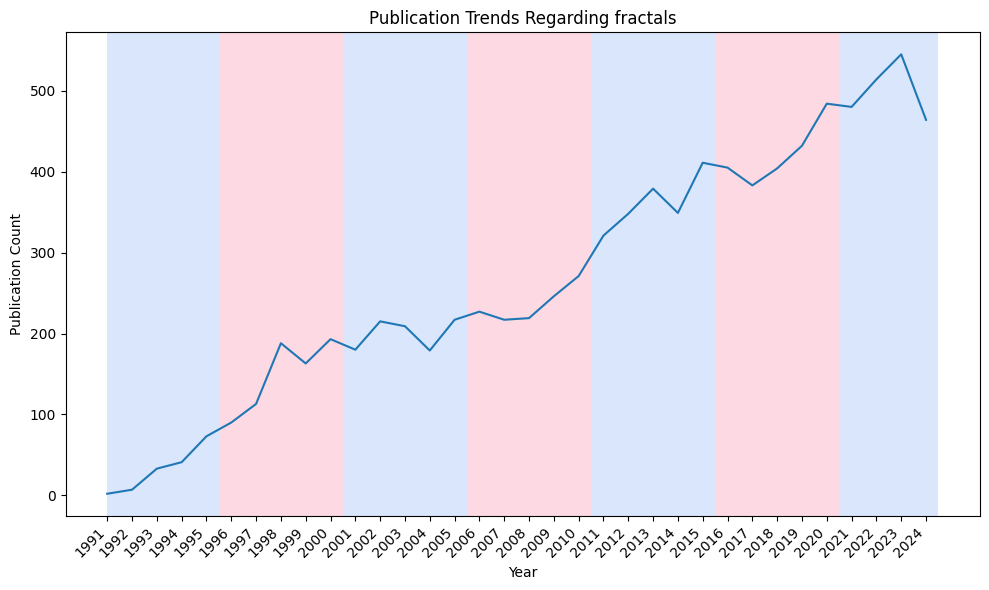

In [118]:
# Extract years and values for plotting
years = publications_per_year_df['year'].values

# Plot results with years on the x-axis
fig, ax_arr = rpt.display(values, my_bkps, figsize=(10, 6))
# Adjust the x-axis to show years instead of indices
ax_arr[0].set_xticks(range(len(years)))  # Set x-ticks based on the number of years
ax_arr[0].set_xticklabels(years, rotation=45, ha="right")  # Label x-ticks with years

# Set axis labels
ax_arr[0].set_xlabel("Year")
ax_arr[0].set_ylabel("Publication Count")
plt.title("Publication Trends Regarding " + query_subject)
plt.tight_layout()
plt.show()

In [107]:
publications_per_year_df

,year,publication_count
0,1991,2
1,1992,7
2,1993,33
3,1994,41
4,1995,73
5,1996,90
6,1997,113
7,1998,188
8,1999,163
9,2000,193


# Functions for Streamlining Real-Time Use

In [ ]:
# Function to fetch data from arXiv
def fetch_arxiv_data(query, max_results=1000):
    base_url = "http://export.arxiv.org/api/query?"
    params = f"search_query={query}&start=0&max_results={max_results}&sortBy=submittedDate&sortOrder=ascending"
    response = requests.get(base_url + params)
    return feedparser.parse(response.text)

query_subject = "fractals"
# Example: Get publications mentioning the specified subject
query = f"all:{query_subject}"
data = fetch_arxiv_data(query)

# Parse data into a DataFrame
records = []
for entry in data.entries:
    pub_date = datetime.strptime(entry.published, "%Y-%m-%dT%H:%M:%SZ")
    records.append({
        "title": entry.title,
        "published_year": pub_date.year
    })
df = pd.DataFrame(records)

# Group by year and count publications
publications_per_year = df['published_year'].value_counts().sort_index()
# Convert the publications_per_year series into a DataFrame
publications_per_year_df = publications_per_year.reset_index()
# Rename the columns for clarity
publications_per_year_df.columns = ["year", "publication_count"]

# extract the value_as_float column as a numpy array
values = publications_per_year_df['publication_count'].values

In [126]:
def change_pt_detect(values):
    # change point detection
    model = "l1"  # "l2", "rbf"
    algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(values)
    my_bkps = algo.predict(pen=10)
    
    # show results
    fig, ax_arr = rpt.display(values, my_bkps, figsize=(5, 3))
    plt.show()

    # save fig to file
    folder_path = "plots"
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"figure_{current_time}.jpg"
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, format="jpeg")

    # Extract years and values for plotting
    years = publications_per_year_df['year'].values
    
    # Plot results with years on the x-axis
    fig, ax_arr = rpt.display(values, my_bkps, figsize=(10, 6))
    # Adjust the x-axis to show years instead of indices
    ax_arr[0].set_xticks(range(len(years)))  # Set x-ticks based on the number of years
    ax_arr[0].set_xticklabels(years, rotation=45, ha="right")  # Label x-ticks with years
    
    # Set axis labels
    ax_arr[0].set_xlabel("Year")
    ax_arr[0].set_ylabel("Publication Count")
    plt.title("Publication Trends Regarding " + query_subject)
    plt.tight_layout()
    plt.show()

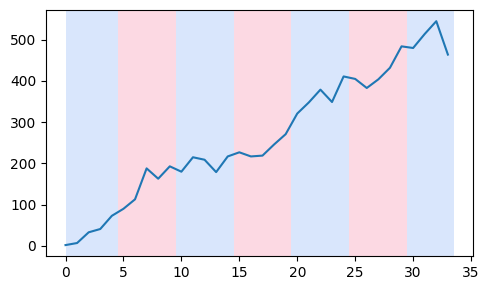

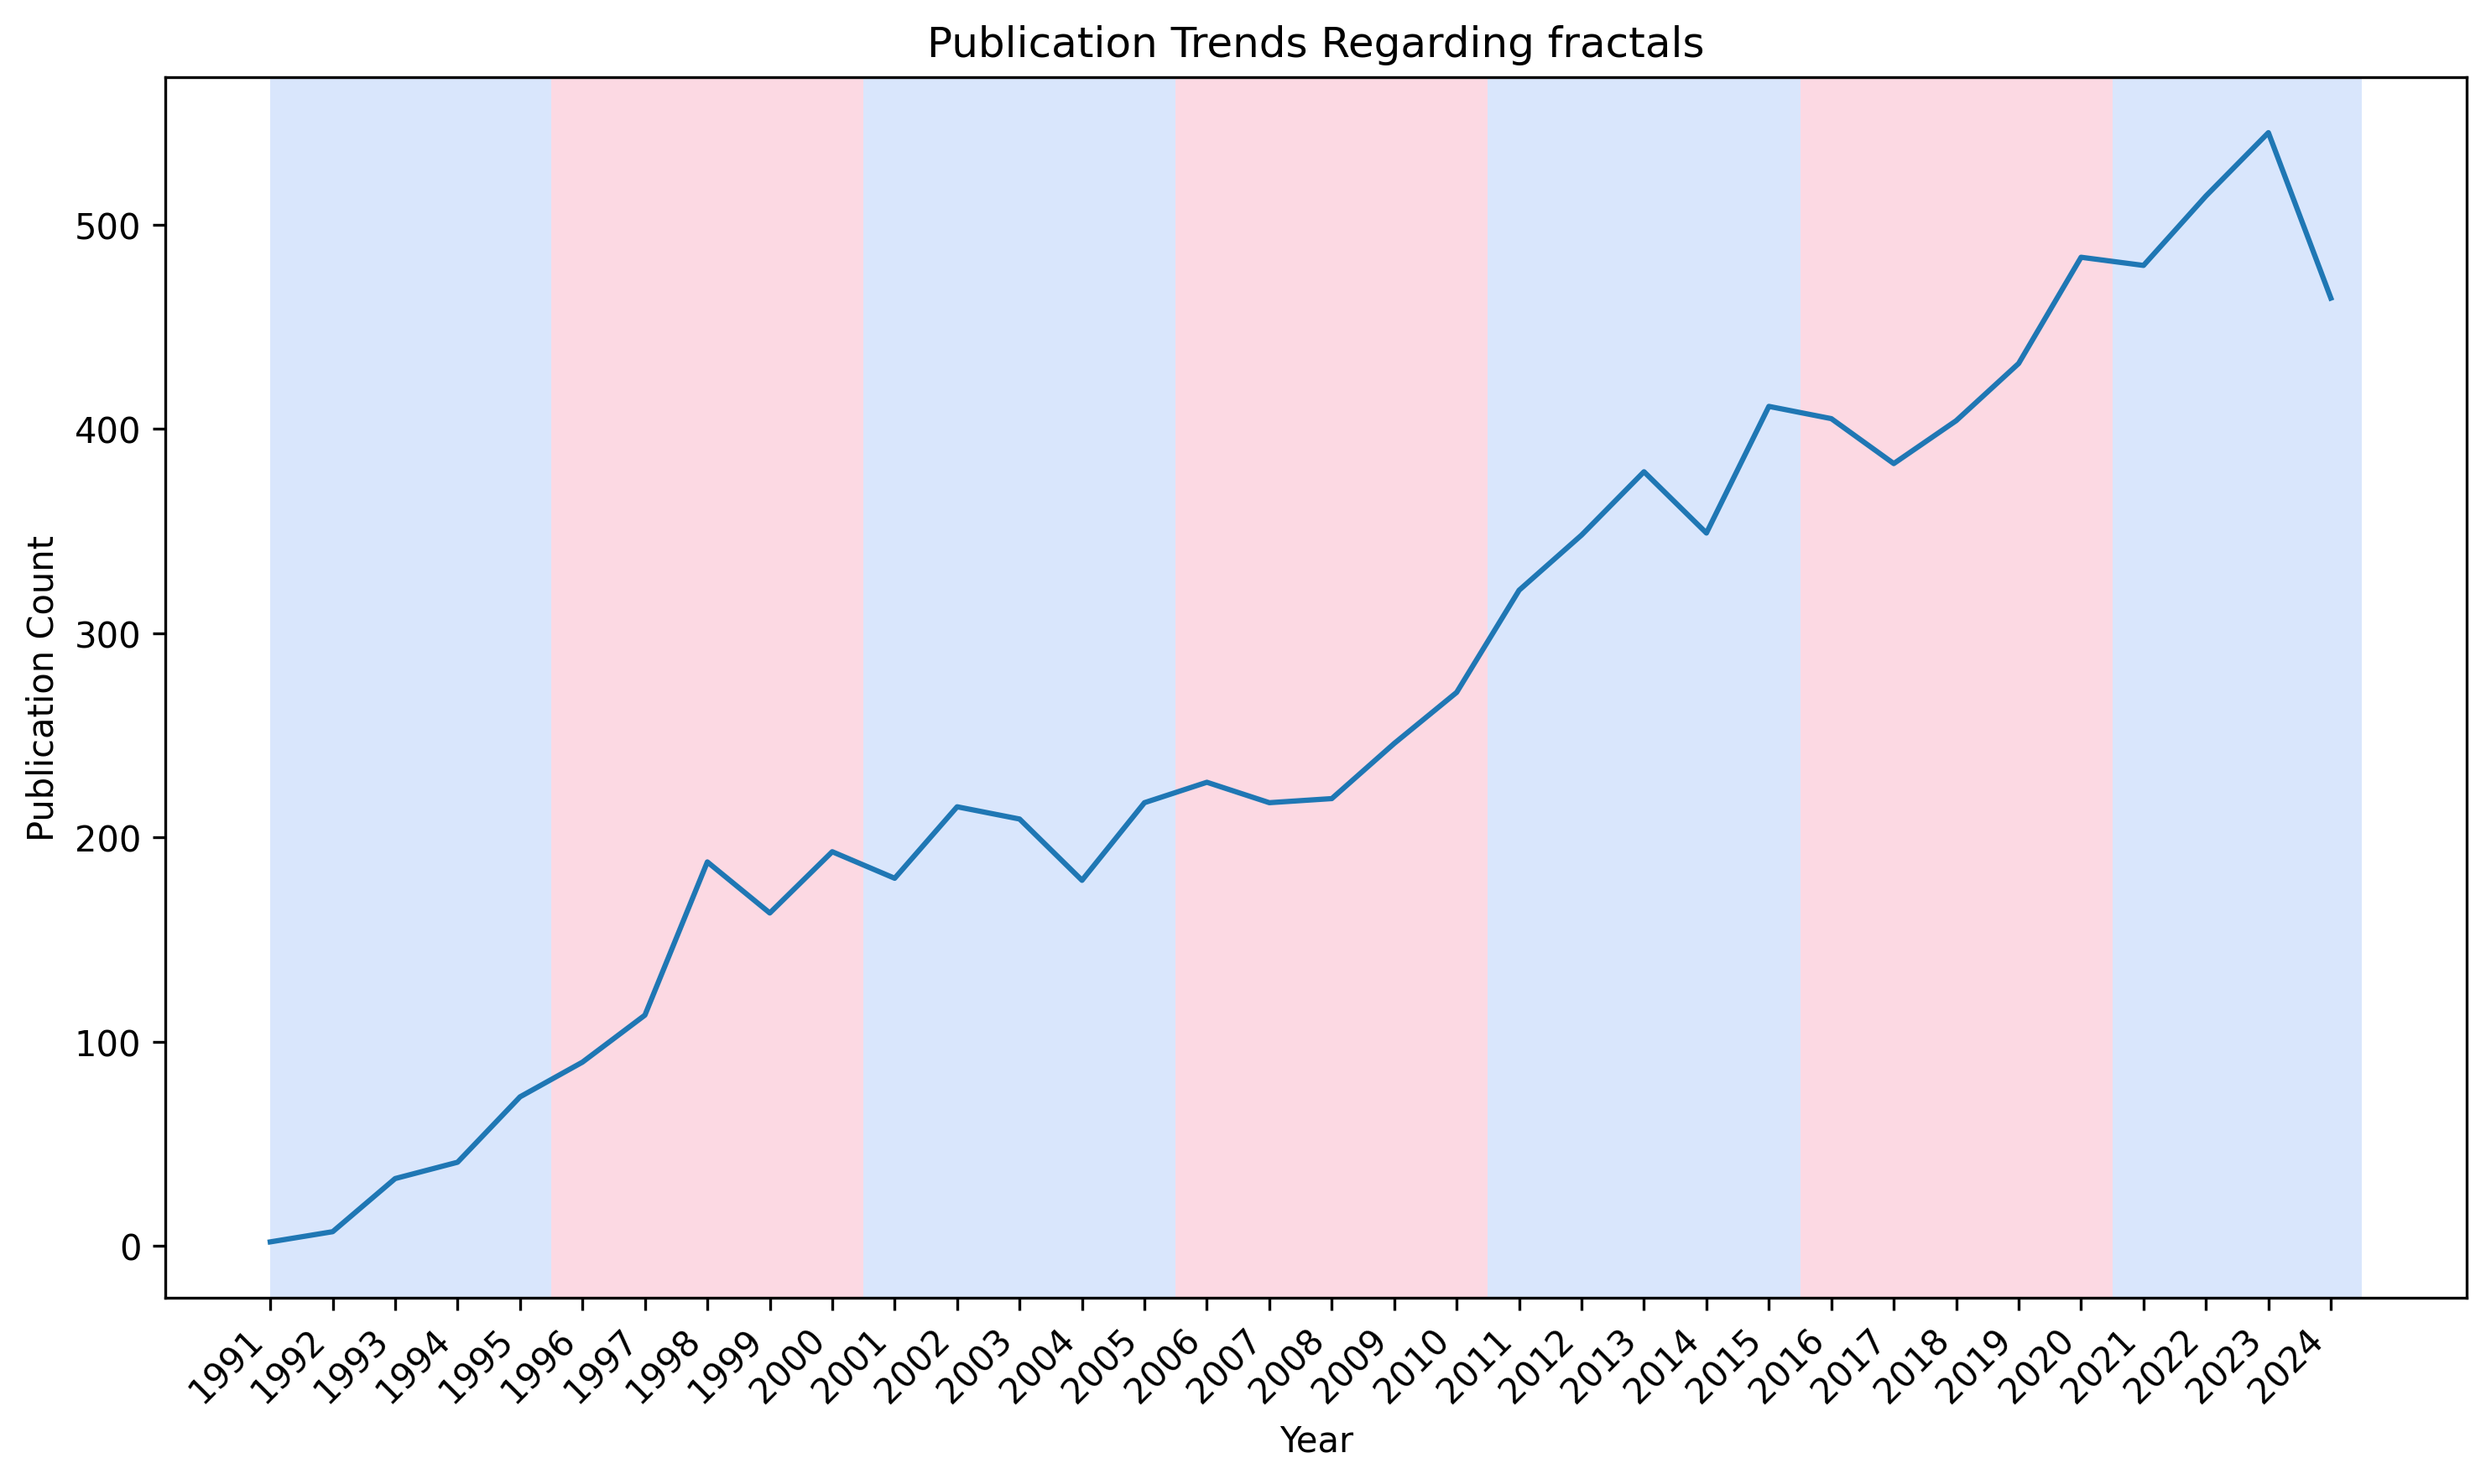

In [127]:
change_pt_detect(values)

In [125]:
img_analyze()



Analysis:  ```json
{
  "segmentation": [
    {
      "segment": 1,
      "start": 0,
      "end": 10,
      "mean_value": 50
    },
    {
      "segment": 2,
      "start": 10,
      "end": 20,
      "mean_value": 100
    },
    {
      "segment": 3,
      "start": 20,
      "end": 30,
      "mean_value": 300
    },
    {
      "segment": 4,
      "start": 30,
      "end": 35,
      "mean_value": 500
    }
  ],
  "evaluation": {
    "dotted_lines_placement": "The dotted lines appear to delineate segments that show differing trends in the data, indicating potential change points.",
    "trend_shift": "A noticeable trend shift occurs at the segments, with increasing values in later segments."
  },
  "final_evaluation": 8,
  "binary_indicator": 1
}
```


# Try out on more real life datasets

In [134]:
# Function to fetch data from arXiv
def fetch_arxiv_data_month(query, max_results=10000):
    base_url = "http://export.arxiv.org/api/query?"
    params = f"search_query={query}&start=0&max_results={max_results}&sortBy=submittedDate&sortOrder=ascending"
    response = requests.get(base_url + params)
    return feedparser.parse(response.text)

query_subject = "ChatGPT"
# Example: Get publications mentioning the specified subject
query = f"all:{query_subject}"
data = fetch_arxiv_data_month(query)

# Parse data into a DataFrame
records = []
for entry in data.entries:
    pub_date = datetime.strptime(entry.published, "%Y-%m-%dT%H:%M:%SZ")
    records.append({
        "title": entry.title,
        "published_year": pub_date.year,
        "published_month": pub_date.month  # Extract month
    })
df = pd.DataFrame(records)

# Group by year and month and count publications
publications_per_month = df.groupby(['published_year', 'published_month']).size().reset_index(name='publication_count')

# Create a 'year_month' column for easier plotting and analysis
publications_per_month['year_month'] = publications_per_month.apply(lambda row: f"{row['published_year']}-{row['published_month']:02d}", axis=1)

# Extract the publication count values as a numpy array
values = publications_per_month['publication_count'].values

# Print the resulting DataFrame for verification
print(publications_per_month)

    published_year  published_month  publication_count year_month
0             2021                1                  1    2021-01
1             2021                4                  1    2021-04
2             2021                9                  1    2021-09
3             2021               12                  1    2021-12
4             2022                5                  1    2022-05
5             2022                6                  3    2022-06
6             2022                7                  1    2022-07
7             2022                8                  3    2022-08
8             2022                9                  1    2022-09
9             2022               10                  3    2022-10
10            2022               11                  6    2022-11
11            2022               12                 14    2022-12
12            2023                1                 23    2023-01
13            2023                2                 61    2023-02
14        

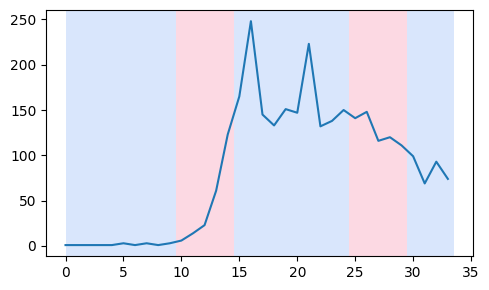

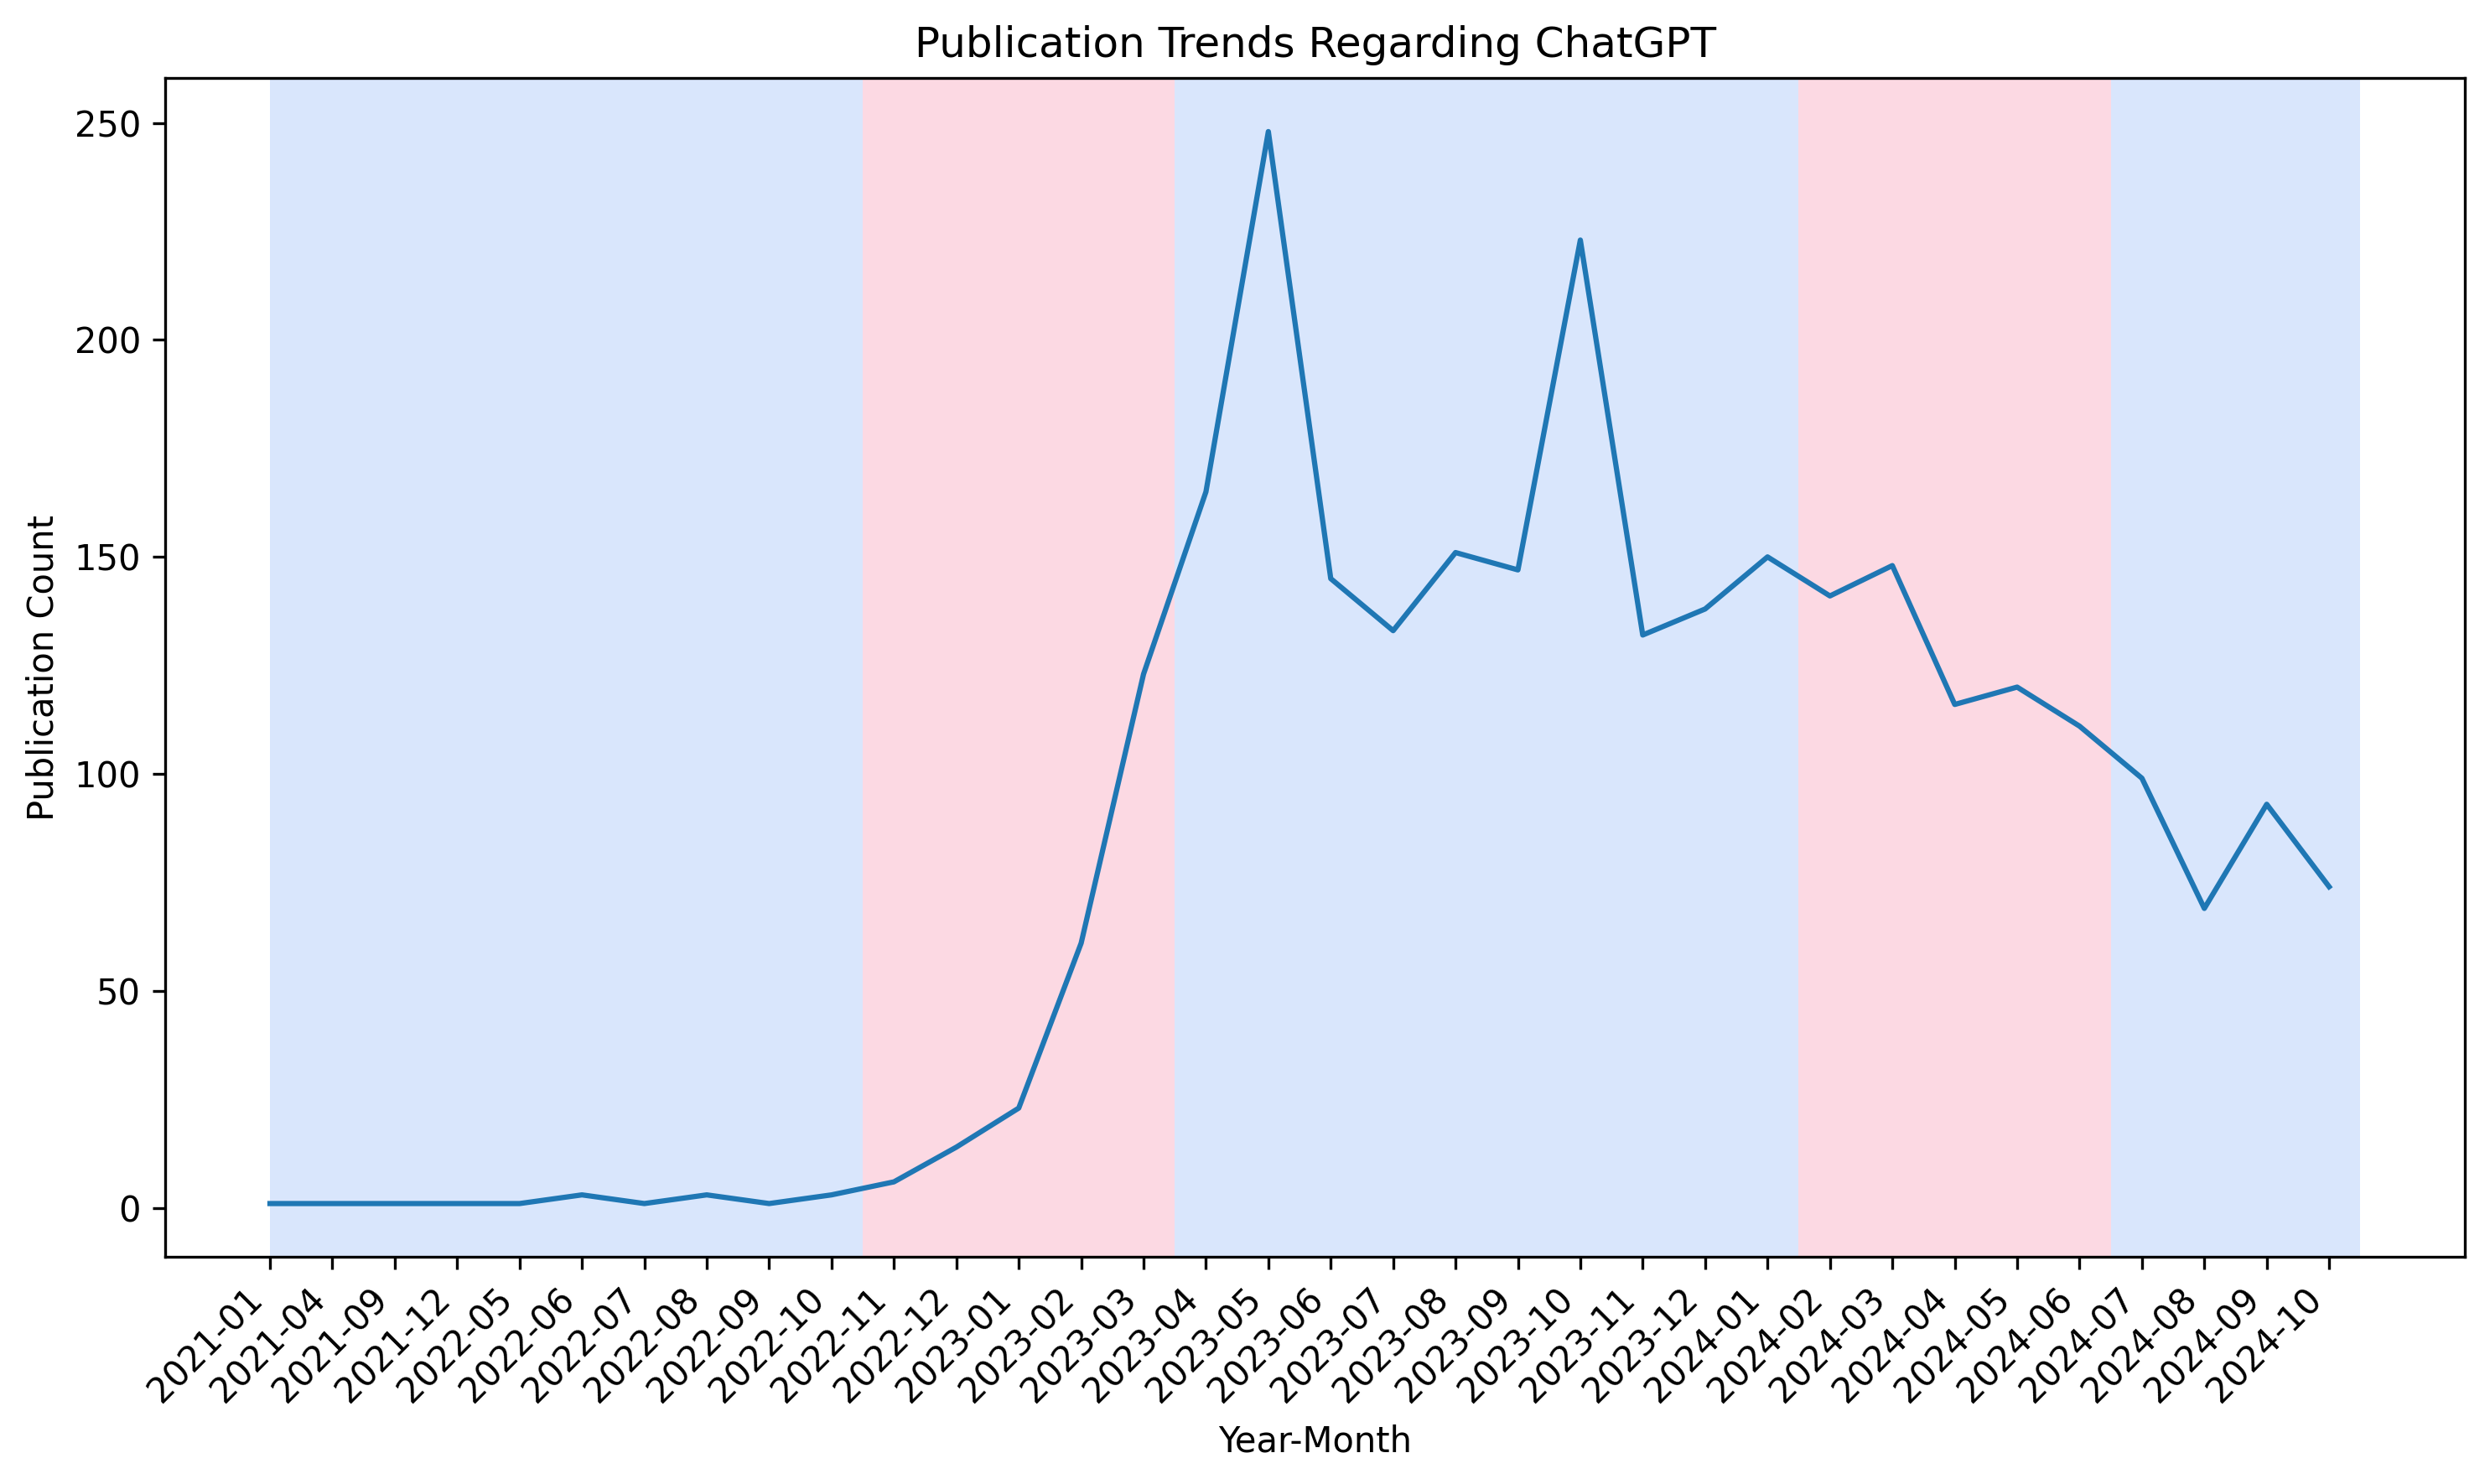

In [143]:
def change_pt_detect(values, publications_per_month_df, query_subject):
    # Change point detection
    model = "l1"  # "l2", "rbf"
    algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(values)
    my_bkps = algo.predict(pen=10)
    
    # Show results
    fig, ax_arr = rpt.display(values, my_bkps, figsize=(5, 3))
    plt.show()

    # Save fig to file
    folder_path = "plots"
    os.makedirs(folder_path, exist_ok=True)  # Ensure the folder exists
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"figure_{current_time}.jpg"
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, format="jpeg")

    # Extract year_month and values for plotting
    year_months = publications_per_month_df['year_month'].values
    
    # Plot results with year_month on the x-axis
    fig, ax_arr = rpt.display(values, my_bkps, figsize=(10, 6))
    
    # Adjust the x-axis to show year_month instead of indices
    ax_arr[0].set_xticks(range(len(year_months)))  # Set x-ticks based on the number of months
    ax_arr[0].set_xticklabels(year_months, rotation=45, ha="right")  # Label x-ticks with year_month
    
    # Set axis labels
    ax_arr[0].set_xlabel("Year-Month")
    ax_arr[0].set_ylabel("Publication Count")
    plt.title("Publication Trends Regarding " + query_subject)    
    plt.tight_layout()
    plt.show()

change_pt_detect(publications_per_month['publication_count'].values, publications_per_month, query_subject)


In [142]:
img_analyze()



Analysis:  ```json
{
  "segmentation": {
    "change_points": [10, 17, 25],
    "segments": [
      {"start": 0, "end": 10},
      {"start": 10, "end": 17},
      {"start": 17, "end": 25},
      {"start": 25, "end": 35}
    ]
  },
  "evaluation": {
    "change_point_locations": "The detected change points appear to align with visible shifts in the data trends, particularly around points of rapid increase and decrease.",
    "trend_analysis": "The segments show varied trends, especially with a notable peak at the second segment and a decline in the last segment."
  },
  "final_evaluation": {
    "score": 8,
    "reason": "The change points are placed reasonably, capturing significant alterations in the data's behavior.",
    "suggestions": "Further validation with statistical methods could enhance confidence in the detected changes."
  },
  "binary_indicator": 1
}
```


In [183]:
# Function to fetch data from arXiv
def fetch_arxiv_data(query, max_results=2000):
    base_url = "http://export.arxiv.org/api/query?"
    params = f"search_query={query}&start=0&max_results={max_results}&sortBy=submittedDate&sortOrder=ascending"
    response = requests.get(base_url + params)
    return feedparser.parse(response.text)

query_subject = "ellipse"
# Get publications mentioning the specified subject
query = f"all:{query_subject}"
data = fetch_arxiv_data(query)

# Parse data 
records = []
for entry in data.entries:
    pub_date = datetime.strptime(entry.published, "%Y-%m-%dT%H:%M:%SZ")
    records.append({
        "title": entry.title,
        "published_year": pub_date.year
    })
df = pd.DataFrame(records)
publications_per_year = df['published_year'].value_counts().sort_index()
publications_per_year_df = publications_per_year.reset_index()
publications_per_year_df.columns = ["year", "publication_count"]
values = publications_per_year_df['publication_count'].values

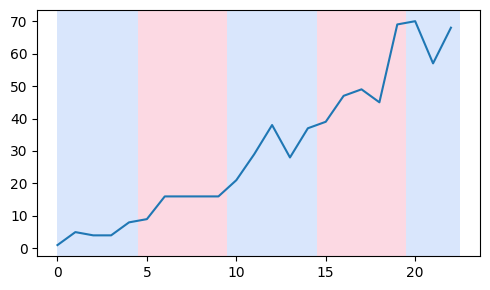

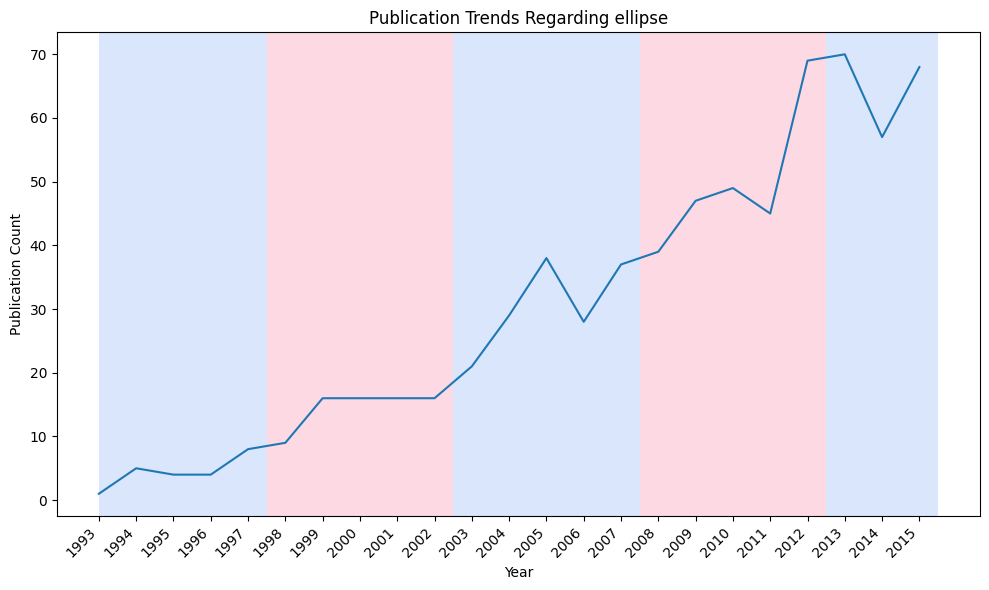

In [184]:
def change_pt_detect(values):
    # change point detection
    model = "l1"  # "l2", "rbf"
    algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(values)
    my_bkps = algo.predict(pen=10)
    
    fig, ax_arr = rpt.display(values, my_bkps, figsize=(5, 3))
    plt.show()

    # save fig to file
    folder_path = "plots"
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"figure_{current_time}.jpg"
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, format="jpeg")

    years = publications_per_year_df['year'].values
    
    # Plot results with years on the x-axis
    fig, ax_arr = rpt.display(values, my_bkps, figsize=(10, 6))
    ax_arr[0].set_xticks(range(len(years)))  
    ax_arr[0].set_xticklabels(years, rotation=45, ha="right") 
    ax_arr[0].set_xlabel("Year")
    ax_arr[0].set_ylabel("Publication Count")
    plt.title("Publication Trends Regarding " + query_subject)
    plt.tight_layout()
    plt.show()

change_pt_detect(values)

In [182]:
img_analyze()



Analysis:  ```json
{
  "evaluation": "The change points are detected around the transitions between the blue and pink regions. The pink area seems to indicate a significant change in the trend of the data. The changes look reasonable as there is a noticeable shift present and the data in the pink region appears distinct compared to the surrounding blue regions. However, the overall amplitude and stability before and after the change point could be more pronounced for a stronger validation.",
  "score": 7,
  "final_evaluation": "Promising",
  "binary_indicator": 1
}
```
